Submitted by:
Maham Waseem (27257) 

Hierarchical Clustering

Importing the required dependencies

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Creating Functions 
</br>
1-LoadData </br>
2-CleanFun </br>
3-KYFS </br>
4-FTRsclt </br>
5-PCAViz </br>
6-ClusterFun </br>
7-VizFun </br>

1. LoadData

In [5]:
import chardet
import pandas as pd

def LoadData(Loc):
    # Read the raw data to detect encoding
    rawdata = open(Loc, 'rb').read()
    result = chardet.detect(rawdata)

    # Read the CSV file using the detected encoding
    data = pd.read_csv(Loc, encoding=result['encoding'])

    return data



Noise Removal Function

In [8]:
import pandas as pd

def remove_outliers_iqr(data):
    # Copy the data to avoid modifying the original data
    clean_data = data.copy()

    # Loop through each column in the data
    for column in clean_data.select_dtypes(include=['float64', 'int64']).columns:  # Only numeric columns
        Q1 = clean_data[column].quantile(0.25)  # 1st quartile
        Q3 = clean_data[column].quantile(0.75)  # 3rd quartile
        IQR = Q3 - Q1  # Interquartile Range
        
        # Calculate the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter the data to remove outliers
        clean_data = clean_data[(clean_data[column] >= lower_bound) & (clean_data[column] <= upper_bound)]
        
    return clean_data


2. CleanFun

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

def CleanData(df):
    """
    Generalized function to clean a dataset with categorical, integer, binary, continuous, and boolean data types.
    - Automatically handles missing values, encodes categorical data, and scales continuous and integer data.
    
    Parameters:
    - df: The input DataFrame.
    
    Returns:
    - df_cleaned: The cleaned and transformed DataFrame.
    """
    # Step 1: Handle special missing value representations ("?" in this dataset)
    df.replace('?', np.nan, inplace=True)
    
    # Step 2: Detect column types
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    integer_cols = df.select_dtypes(include=['int64', 'int32']).columns.tolist()
    
    # Detect binary columns (those with exactly 2 unique values)
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]
    
    # Detect boolean columns
    boolean_cols = df.select_dtypes(include=['bool']).columns.tolist()

    # Convert boolean columns to integers (0 and 1)
    df[boolean_cols] = df[boolean_cols].astype(int)

    # Remove binary and boolean columns from integer cols since they are handled separately
    integer_cols = [col for col in integer_cols if col not in binary_cols + boolean_cols]

    # Step 3: Handle missing values
    # Fill missing continuous values with the mean
    if continuous_cols:
        imputer_cont = SimpleImputer(strategy='mean')
        df[continuous_cols] = imputer_cont.fit_transform(df[continuous_cols])
    
    # Fill missing integer values with the median
    if integer_cols:
        imputer_int = SimpleImputer(strategy='median')
        df[integer_cols] = imputer_int.fit_transform(df[integer_cols])
    
    # Fill missing categorical values with the most frequent value (mode)
    if categorical_cols:
        imputer_cat = SimpleImputer(strategy='most_frequent')
        df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])
    
    # Fill missing binary values with the mode
    if binary_cols:
        imputer_bin = SimpleImputer(strategy='most_frequent')
        df[binary_cols] = imputer_bin.fit_transform(df[binary_cols])
    
    # Step 4: Encode categorical variables (One-hot encoding)
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    # Step 5: Scale continuous and integer variables
    scaler = StandardScaler()
    if continuous_cols:
        df_encoded[continuous_cols] = scaler.fit_transform(df_encoded[continuous_cols])
    if integer_cols:
        df_encoded[integer_cols] = scaler.fit_transform(df_encoded[integer_cols])
    
    return df_encoded



In [13]:

def list_columns_with_missing_values(df):
    result=df.isnull().sum(0)
    return result


def drop_null(df): #This function will clean the dataset by dropping null values.
    df.dropna(inplace=True)
    return(df)


def fill_null_mean(df):

    df_float = df.select_dtypes(include='float64').columns.tolist()
    # Make a copy of float columns
    X = df[df_float].copy()

    # Calculate means of each column
    means = X.mean()

    # Fill missing values with mean values
    X.fillna(value=means, inplace=True)

    # Assign the filled float columns back to the original DataFrame
    df[df_float] = X

    return df



def CleanFun(data): #This function will clean the dataset.
    
    print("Number of missing values in your data set:",list_columns_with_missing_values(data))

    print("Number of duplicate rows in your data set:",data.duplicated().sum())
    print("All the missing values have been filled wtih mean values")
    print("All the duplicate rows have been deleted from data set")
    
 
    data.drop_duplicates(inplace=True)
    data = fill_null_mean(data)
    return(data)




3. KYFS

In [16]:
def KYFS(df):

    desc = pd.DataFrame(index = list(df))
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] / len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc['min'] = df.min()
    desc['max'] = df.max()
    return desc;

In [18]:
def ViewColumnTypes(df):
    """
    View which columns are categorical, continuous, integer, and binary.

    Parameters:
    - df: The input DataFrame.

    Returns:
    - A dictionary containing column names categorized by type.
    """
    # Step 1: Get columns by data types
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    integer_cols = df.select_dtypes(include=['int64', 'int32']).columns.tolist()
    
    # Step 2: Identify binary columns (those with exactly two unique values)
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]
    
    # Print the results
    print(f"Categorical Columns: {categorical_cols}")
    print(f"Continuous Columns: {continuous_cols}")
    print(f"Integer Columns: {integer_cols}")
    print(f"Binary Columns: {binary_cols}")
    
    # Return the results in a dictionary (for potential future use)
    return {
        "categorical_cols": categorical_cols,
        "continuous_cols": continuous_cols,
        "integer_cols": integer_cols,
        "binary_cols": binary_cols
    }


4. FTRsclt

In [21]:
def FtrSlct(df, hist_color='MAROON', boxplot_color='MAROON'):
    # Separating numerical and categorical features
    numeric_features = df.select_dtypes(include=['float64','int64','int32'])
    categorical_features = df.select_dtypes(include=['object', 'int64'])

    # Summary statistics
    summary_stats = numeric_features.describe().style.set_properties(**{'color': 'maroon', 'text-align': 'center', 'font-weight': 'bold'})
    print("\n\033[1m\033[91mSummary Statistics:\033[0m")
    display(summary_stats)


    num_cols = len(numeric_features.columns)
    num_rows = (num_cols - 1) // 3 + 1  # Calculate number of rows needed

    # Histograms and Box plots
    fig, axes = plt.subplots(nrows=num_rows*2, ncols=3, figsize=(16, 5*num_rows))

    for i, column in enumerate(numeric_features.columns):
        row = i // 3
        col = i % 3

        sns.histplot(df[column], bins=20, kde=True, color=hist_color, ax=axes[row*2, col])
        axes[row*2, col].set_title(f'Histogram of {column}')
        axes[row*2, col].set_xlabel(column)
        axes[row*2, col].set_ylabel('Frequency')

        sns.boxplot(data=df, y=column, color=boxplot_color, ax=axes[row*2+1, col])
        axes[row*2+1, col].set_title(f'Boxplot of {column}')
        axes[row*2+1, col].set_ylabel(column)

    plt.tight_layout()
    plt.show()

    # Correlation matrix
    # Calculate correlation matrix
    correlation_matrix = numeric_features.corr()

    # Correlation matrix
    plt.figure(figsize=(30, 30))
    sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=1)
    plt.title('Correlation Heatmap of 30 Variables')
    plt.xlabel('Variables')
    plt.ylabel('Variables')
    plt.show()



Normalization

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Function to plot k-distance graph and mark the epsilon point
def k_distance_graph(data):
    # Automatically calculate min_pts based on the heuristic
    min_pts = 2 * data.shape[1]  # MinPts heuristic: MinPts = 2 * Dimensionality
    
    # Step 1: Compute distances to k-th nearest neighbor (MinPts - 1)
    neighbors = NearestNeighbors(n_neighbors=min_pts)
    neighbors.fit(data)
    distances, indices = neighbors.kneighbors(data)
    
    # Step 2: Sort the distances
    sorted_distances = np.sort(distances[:, -1])
    
    # Step 3: Find the elbow point
    # We can use the second derivative to find where the slope increases most
    diff = np.diff(sorted_distances)
    diff2 = np.diff(diff)
    elbow_point = np.argmax(diff2) + 1  # +1 because diff2 is 1 element shorter than diff
    
    # Epsilon is the distance corresponding to the elbow point
    epsilon = sorted_distances[elbow_point]
    
    # Step 4: Plot the k-distance graph and mark the epsilon point
    plt.plot(sorted_distances, label="K-distance graph")
    plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Epsilon (ε) = {epsilon:.2f}')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to the {min_pts-1}-th nearest neighbor')
    plt.title(f'K-distance Graph with Epsilon Marked (MinPts = {min_pts})')
    plt.legend()
    plt.show()
    
    # Return sorted distances and epsilon value for further analysis
    return sorted_distances, epsilon



Grid Search with TSNE

In [281]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def tsne_perform_clustering_and_plot(data):
    # Define parameter grid for DBSCAN and OPTICS
    eps_values = np.linspace(0.4, 0.6, 10)  # Example range for `eps` (adjust as needed)
    min_samples_values = np.arange(11, 16, 2)  # Example range for `min_samples`

    # Prepare lists to store results
    results_dbscan = []
    results_optics = []

    # DBSCAN Grid Search
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=int(min_samples))
            dbscan_labels = dbscan.fit_predict(data)
            n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
            noise_points_dbscan = np.sum(dbscan_labels == -1)
            results_dbscan.append([eps, int(min_samples), n_clusters_dbscan, noise_points_dbscan])

    # OPTICS Grid Search
    for max_eps in eps_values:  # For OPTICS, `max_eps` is the threshold for reachability
        for min_samples in min_samples_values:
            optics = OPTICS(max_eps=max_eps, min_samples=int(min_samples))
            optics_labels = optics.fit_predict(data)
            n_clusters_optics = len(set(optics_labels)) - (1 if -1 in optics_labels else 0)
            noise_points_optics = np.sum(optics_labels == -1)
            results_optics.append([max_eps, int(min_samples), n_clusters_optics, noise_points_optics])

    # Convert results to DataFrames
    df_dbscan = pd.DataFrame(results_dbscan, columns=['eps', 'min_samples', 'n_clusters', 'noise_points'])
    df_optics = pd.DataFrame(results_optics, columns=['max_eps', 'min_samples', 'n_clusters', 'noise_points'])

    # Select top models for visualization
    df_dbscan_sorted = df_dbscan.sort_values(by=['n_clusters', 'noise_points'], ascending=[False, True]).head(3)
    df_optics_sorted = df_optics.sort_values(by=['n_clusters', 'noise_points'], ascending=[False, True]).head(3)

    best_dbscan_models = []
    best_optics_models = []

    # Instantiate best DBSCAN and OPTICS models
    for i in range(3):
        best_dbscan = DBSCAN(eps=df_dbscan_sorted.iloc[i]['eps'], min_samples=int(df_dbscan_sorted.iloc[i]['min_samples']))
        best_optics = OPTICS(max_eps=df_optics_sorted.iloc[i]['max_eps'], min_samples=int(df_optics_sorted.iloc[i]['min_samples']))

        best_dbscan_models.append(best_dbscan)
        best_optics_models.append(best_optics)

    # Reduce data to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(data)

    # Plot results
    plt.figure(figsize=(15, 12))
    plt.suptitle("TSNE Plot", fontsize=16)  # Main heading for the entire plot

    # DBSCAN Visualization
    for i, dbscan_model in enumerate(best_dbscan_models):
        dbscan_labels = dbscan_model.fit_predict(data)
        n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        noise_points_dbscan = np.sum(dbscan_labels == -1)
        
        plt.subplot(3, 2, i * 2 + 1)
        plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=dbscan_labels, cmap='viridis')
        plt.title(f'DBSCAN (eps={dbscan_model.eps}, min_samples={dbscan_model.min_samples}, clusters={n_clusters_dbscan}, noise={noise_points_dbscan})')
        plt.colorbar()

    # OPTICS Visualization
    for i, optics_model in enumerate(best_optics_models):
        optics_labels = optics_model.fit_predict(data)
        n_clusters_optics = len(set(optics_labels)) - (1 if -1 in optics_labels else 0)
        noise_points_optics = np.sum(optics_labels == -1)
        
        plt.subplot(3, 2, i * 2 + 2)
        plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=optics_labels, cmap='viridis')
        plt.title(f'OPTICS (max_eps={optics_model.max_eps}, min_samples={optics_model.min_samples}, clusters={n_clusters_optics}, noise={noise_points_optics})')
        plt.colorbar()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()


In [ ]:
PCA Visualization

In [287]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def perform_clustering_and_plot(data, dbscan_params, optics_params):
    # Unpack DBSCAN and OPTICS parameters
    eps, min_samples_dbscan = dbscan_params
    max_eps, min_samples_optics = optics_params

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples_dbscan)
    dbscan_labels = dbscan.fit_predict(data)
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    noise_points_dbscan = np.sum(dbscan_labels == -1)

    # OPTICS Clustering
    optics = OPTICS(max_eps=max_eps, min_samples=min_samples_optics)
    optics_labels = optics.fit_predict(data)
    n_clusters_optics = len(set(optics_labels)) - (1 if -1 in optics_labels else 0)
    noise_points_optics = np.sum(optics_labels == -1)

    # Reduce data to 2D for visualization using PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)

    # Plot results
    plt.figure(figsize=(15, 12))

    # DBSCAN Visualization
    plt.subplot(1, 2, 1)
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=dbscan_labels, cmap='viridis')
    plt.title(f'DBSCAN (eps={eps}, min_samples={min_samples_dbscan}, clusters={n_clusters_dbscan}, noise={noise_points_dbscan})')
    plt.colorbar()

    # OPTICS Visualization
    plt.subplot(1, 2, 2)
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=optics_labels, cmap='viridis')
    plt.title(f'OPTICS (max_eps={max_eps}, min_samples={min_samples_optics}, clusters={n_clusters_optics}, noise={noise_points_optics})')
    plt.colorbar()

    # Add a main title for the entire plot
    plt.suptitle('PCA', fontsize=16)
    
    plt.tight_layout()
    plt.show()

In [ ]:
DBSCAN optics visuals

In [374]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS

def reachability_plot_and_optics_curves(data, max_eps, min_samples):
    """
    This function generates the Reachability Plot and OPTICS curves via t-SNE.

    :param data: The dataset (must be in a format acceptable by sklearn)
    :param max_eps: The maximum distance for reachability (for OPTICS)
    :param min_samples: The minimum number of points required to form a cluster
    """
    
    # Step 1: Perform t-SNE to reduce dimensionality to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(data)

    # Step 2: Perform OPTICS clustering
    optics = OPTICS(max_eps=max_eps, min_samples=min_samples)
    optics.fit(data)
    
    # Retrieve the reachability distances and ordering from OPTICS
    reachability_distances = optics.reachability_
    ordering = optics.ordering_

    # Step 3: Plot the Reachability Plot with colors
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.title("Reachability Plot")
    # Color the plot based on the reachability distances
    sc = plt.scatter(np.arange(len(reachability_distances)), reachability_distances[ordering], 
                     c=reachability_distances[ordering], cmap='plasma', s=50, alpha=0.7)
    plt.colorbar(sc, label="Reachability Distance")
    plt.xlabel("Ordered Points")
    plt.ylabel("Reachability Distance")
    plt.grid(True)
    
    # Step 4: Plot OPTICS Curves via t-SNE
    plt.subplot(2, 1, 2)
    plt.title("OPTICS Clustering via t-SNE")
    # Scatter plot the t-SNE data with colors corresponding to the OPTICS labels
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=optics.labels_, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(label="Cluster Labels")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'data' is your dataset (e.g., pandas DataFrame or numpy array)
# You can adjust max_eps and min_samples as needed

In [75]:
#Cluster Visualization in High Dimensionality to check all the features working in every single clusters

In [96]:
#Heatmap Function

In [360]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import OPTICS

def HeatmapFeatureMeansWithClustering(df, eps=0.5, minPts_dbscan=5, minPts_optics=5, max_eps=0.1, show_optics=False):
    """
    Plot side-by-side heatmaps showing the normalized mean values of original features
    for each cluster using DBSCAN and OPTICS clustering methods after Min-Max scaling.
    
    Parameters:
    - df: DataFrame with original features.
    - eps: The epsilon parameter for DBSCAN (default is 0.5).
    - minPts_dbscan: The minimum points parameter for DBSCAN (default is 5).
    - minPts_optics: The minimum points parameter for OPTICS (default is 5).
    - max_eps: The maximum epsilon parameter for OPTICS (default is 0.1).
    - show_optics: Boolean flag to show OPTICS clustering results (default is False).
    """
    # Min-Max scaling the features to range [0, 1]
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    # Perform DBSCAN clustering with separate minPts for DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=minPts_dbscan)
    dbscan_labels = dbscan.fit_predict(df_scaled)

    # Perform OPTICS clustering with separate minPts for OPTICS
    optics = OPTICS(min_samples=minPts_optics, max_eps=max_eps)
    optics_labels = optics.fit_predict(df_scaled)

    # Function to plot the heatmap for each clustering method
    def plot_heatmap(data, labels, title, ax):
        # Assign clusters and calculate mean feature values for each cluster
        data['Cluster'] = labels
        cluster_means = data.groupby('Cluster').mean()
        data.drop(columns=['Cluster'], inplace=True)  # Remove 'Cluster' after grouping

        # Plot heatmap of the cluster means
        sns.heatmap(cluster_means, annot=True, cmap="viridis", cbar=True, ax=ax)
        ax.set_title(title, size=15)
        ax.set_xlabel("Features")
        ax.set_ylabel("Clusters")

    # Create side-by-side plots for DBSCAN and OPTICS clustering heatmaps
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Plot DBSCAN clustering results
    plot_heatmap(df_scaled.copy(), dbscan_labels, f'DBSCAN (eps={eps}, minPts={minPts_dbscan})', axs[0])

    # Plot OPTICS clustering results (if show_optics is True)
    if show_optics:
        plot_heatmap(df_scaled.copy(), optics_labels, f'OPTICS (minPts={minPts_optics}, max_eps={max_eps})', axs[1])
    else:
        axs[1].axis('off')  # If OPTICS is not shown, hide the second plot

    plt.tight_layout()  # Adjust subplots to give some padding
    plt.show()


In [104]:
#Radial Plot Visualization

In [368]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import OPTICS

def RadialFeatureMeansWithClustering(df, eps=0.49, minPts_dbscan=11, minPts_optics=13, max_eps=0.49, show_optics=False):
    """
    Plot radial charts showing the normalized mean values of original features
    for each cluster using DBSCAN and OPTICS clustering methods after Min-Max scaling.
    
    Parameters:
    - df: DataFrame with original features.
    - eps: The epsilon parameter for DBSCAN (default is 0.49).
    - minPts_dbscan: The minimum points parameter for DBSCAN (default is 11).
    - minPts_optics: The minimum points parameter for OPTICS (default is 13).
    - max_eps: The maximum epsilon parameter for OPTICS (default is 0.49).
    - show_optics: Boolean flag to show OPTICS clustering results (default is False).
    """
    # Min-Max scaling the features to range [0, 1]
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=minPts_dbscan)
    dbscan_labels = dbscan.fit_predict(df_scaled)

    # Perform OPTICS clustering
    optics = OPTICS(min_samples=minPts_optics, max_eps=max_eps)
    optics_labels = optics.fit_predict(df_scaled)

    # Helper function to plot radial chart for each clustering method
    def plot_radial_chart(data, labels, title, ax):
        data['Cluster'] = labels
        cluster_means = data.groupby('Cluster').mean().reset_index()
        data.drop(columns=['Cluster'], inplace=True)  # Remove 'Cluster' after grouping

        # Create radial chart for each cluster
        categories = list(cluster_means.columns[1:])  # Skip 'Cluster' column
        num_vars = len(categories)

        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the loop for the radial plot

        for i, row in cluster_means.iterrows():
            values = row[1:].tolist()  # Get values for each feature
            values += values[:1]  # Close the loop

            ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {int(row["Cluster"])}')
            ax.fill(angles, values, alpha=0.25)

        ax.set_title(title, size=15)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_yticklabels([])

    # Create side-by-side radial plots for DBSCAN and OPTICS clustering
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(polar=True))

    # Plot DBSCAN clustering results
    plot_radial_chart(df_scaled.copy(), dbscan_labels, f'DBSCAN (eps={eps}, minPts={minPts_dbscan})', axs[0])
    axs[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))  # Add legend for DBSCAN clusters

    # Plot OPTICS clustering results (if show_optics is True)
    if show_optics:
        plot_radial_chart(df_scaled.copy(), optics_labels, f'OPTICS (minPts={minPts_optics}, max_eps={max_eps})', axs[1])
        axs[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))  # Add legend for OPTICS clusters
    else:
        axs[1].axis('off')  # If OPTICS is not shown, hide the second plot

    plt.tight_layout()  # Adjust subplots to give some padding
    plt.show()

# Example usage:
# Assuming `df` is your DataFrame with original features
# RadialFeatureMeansWithClustering(df, eps=0.49, minPts_dbscan=11, minPts_optics=13, max_eps=0.49, show_optics=True)


Master Function

In [313]:
data=LoadData(r'customer_segmentation.xls')

In [315]:
data = data.drop(columns=['ID','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2','Complain','Z_CostContact','Z_Revenue'])

In [317]:
# encoded_data = CleanData(data)

In [319]:
data=CleanFun(data)

Number of missing values in your data set: Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
dtype: int64
Number of duplicate rows in your data set: 201
All the missing values have been filled wtih mean values
All the duplicate rows have been deleted from data set


In [321]:
KYFS(data)

,type,count,nunique,%unique,null,%null,min,max
Year_Birth,int64,2039,59,2.893575,0,0.0,1893,1996
Education,object,2039,5,0.245218,0,0.0,2n Cycle,PhD
Marital_Status,object,2039,8,0.392349,0,0.0,Absurd,YOLO
Income,float64,2039,1975,96.861206,0,0.0,1730.0,666666.0
Kidhome,int64,2039,3,0.147131,0,0.0,0,2
Teenhome,int64,2039,3,0.147131,0,0.0,0,2
Dt_Customer,object,2039,663,32.515939,0,0.0,1/1/2013,9/9/2013
Recency,int64,2039,100,4.904365,0,0.0,0,99
MntWines,int64,2039,776,38.057872,0,0.0,0,1493
MntFruits,int64,2039,158,7.748897,0,0.0,0,199


In [323]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Convert categorical columns to numeric
data['Education'] = label_encoder.fit_transform(data['Education'])  # Encode education
data['Marital_Status'] = label_encoder.fit_transform(data['Marital_Status'])  # Encode marital status
data['Dt_Customer'] = label_encoder.fit_transform(data['Dt_Customer'])  # Encode customer date


In [325]:

# List of features to convert to float
features_to_convert = [
'Year_Birth', 'Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'
]

# Convert specified columns to float
data[features_to_convert] = data[features_to_convert].astype(float)

View types for each feature

In [328]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,1957.0,2.0,4.0,58138.0,0.0,0.0,553.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,8.0,10.0,4.0,7.0
1,1954.0,2.0,4.0,46344.0,1.0,1.0,629.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,1.0,1.0,2.0,5.0
2,1965.0,2.0,5.0,71613.0,0.0,0.0,293.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,8.0,2.0,10.0,4.0
3,1984.0,2.0,5.0,26646.0,1.0,0.0,31.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,2.0,0.0,4.0,6.0
4,1981.0,4.0,3.0,58293.0,1.0,0.0,216.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,5.0,5.0,3.0,6.0,5.0


In [330]:
original_data = data
data2 = data

The data is now cleaned

In [245]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,1957.0,2.0,4.0,58138.0,0.0,0.0,553.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,8.0,10.0,4.0,7.0
1,1954.0,2.0,4.0,46344.0,1.0,1.0,629.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,1.0,1.0,2.0,5.0
2,1965.0,2.0,5.0,71613.0,0.0,0.0,293.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,8.0,2.0,10.0,4.0
3,1984.0,2.0,5.0,26646.0,1.0,0.0,31.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,2.0,0.0,4.0,6.0
4,1981.0,4.0,3.0,58293.0,1.0,0.0,216.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,5.0,5.0,3.0,6.0,5.0



Summary Statistics:


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000
mean,1968.768024,2.392349,3.719961,52362.016377,0.444826,0.507602,326.142227,49.096616,303.332026,26.351153,167.755272,37.456596,27.215792,43.760177,2.329083,4.098578,2.658656,5.772437,5.310446
std,11.983086,1.126041,1.072700,25429.606626,0.537843,0.546930,192.317204,28.974507,335.823263,39.824028,227.930430,54.704882,41.701678,52.024687,1.934170,2.799936,2.936390,3.236841,2.438496
min,1893.000000,0.000000,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,2.000000,3.000000,35702.500000,0.000000,0.000000,163.500000,24.000000,23.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000
50%,1970.000000,2.000000,4.000000,52074.000000,0.000000,0.000000,322.000000,49.000000,174.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000
75%,1977.000000,3.000000,5.000000,68298.500000,1.000000,1.000000,494.000000,74.000000,503.500000,33.000000,230.000000,50.000000,34.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000
max,1996.000000,4.000000,7.000000,666666.000000,2.000000,2.000000,662.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000


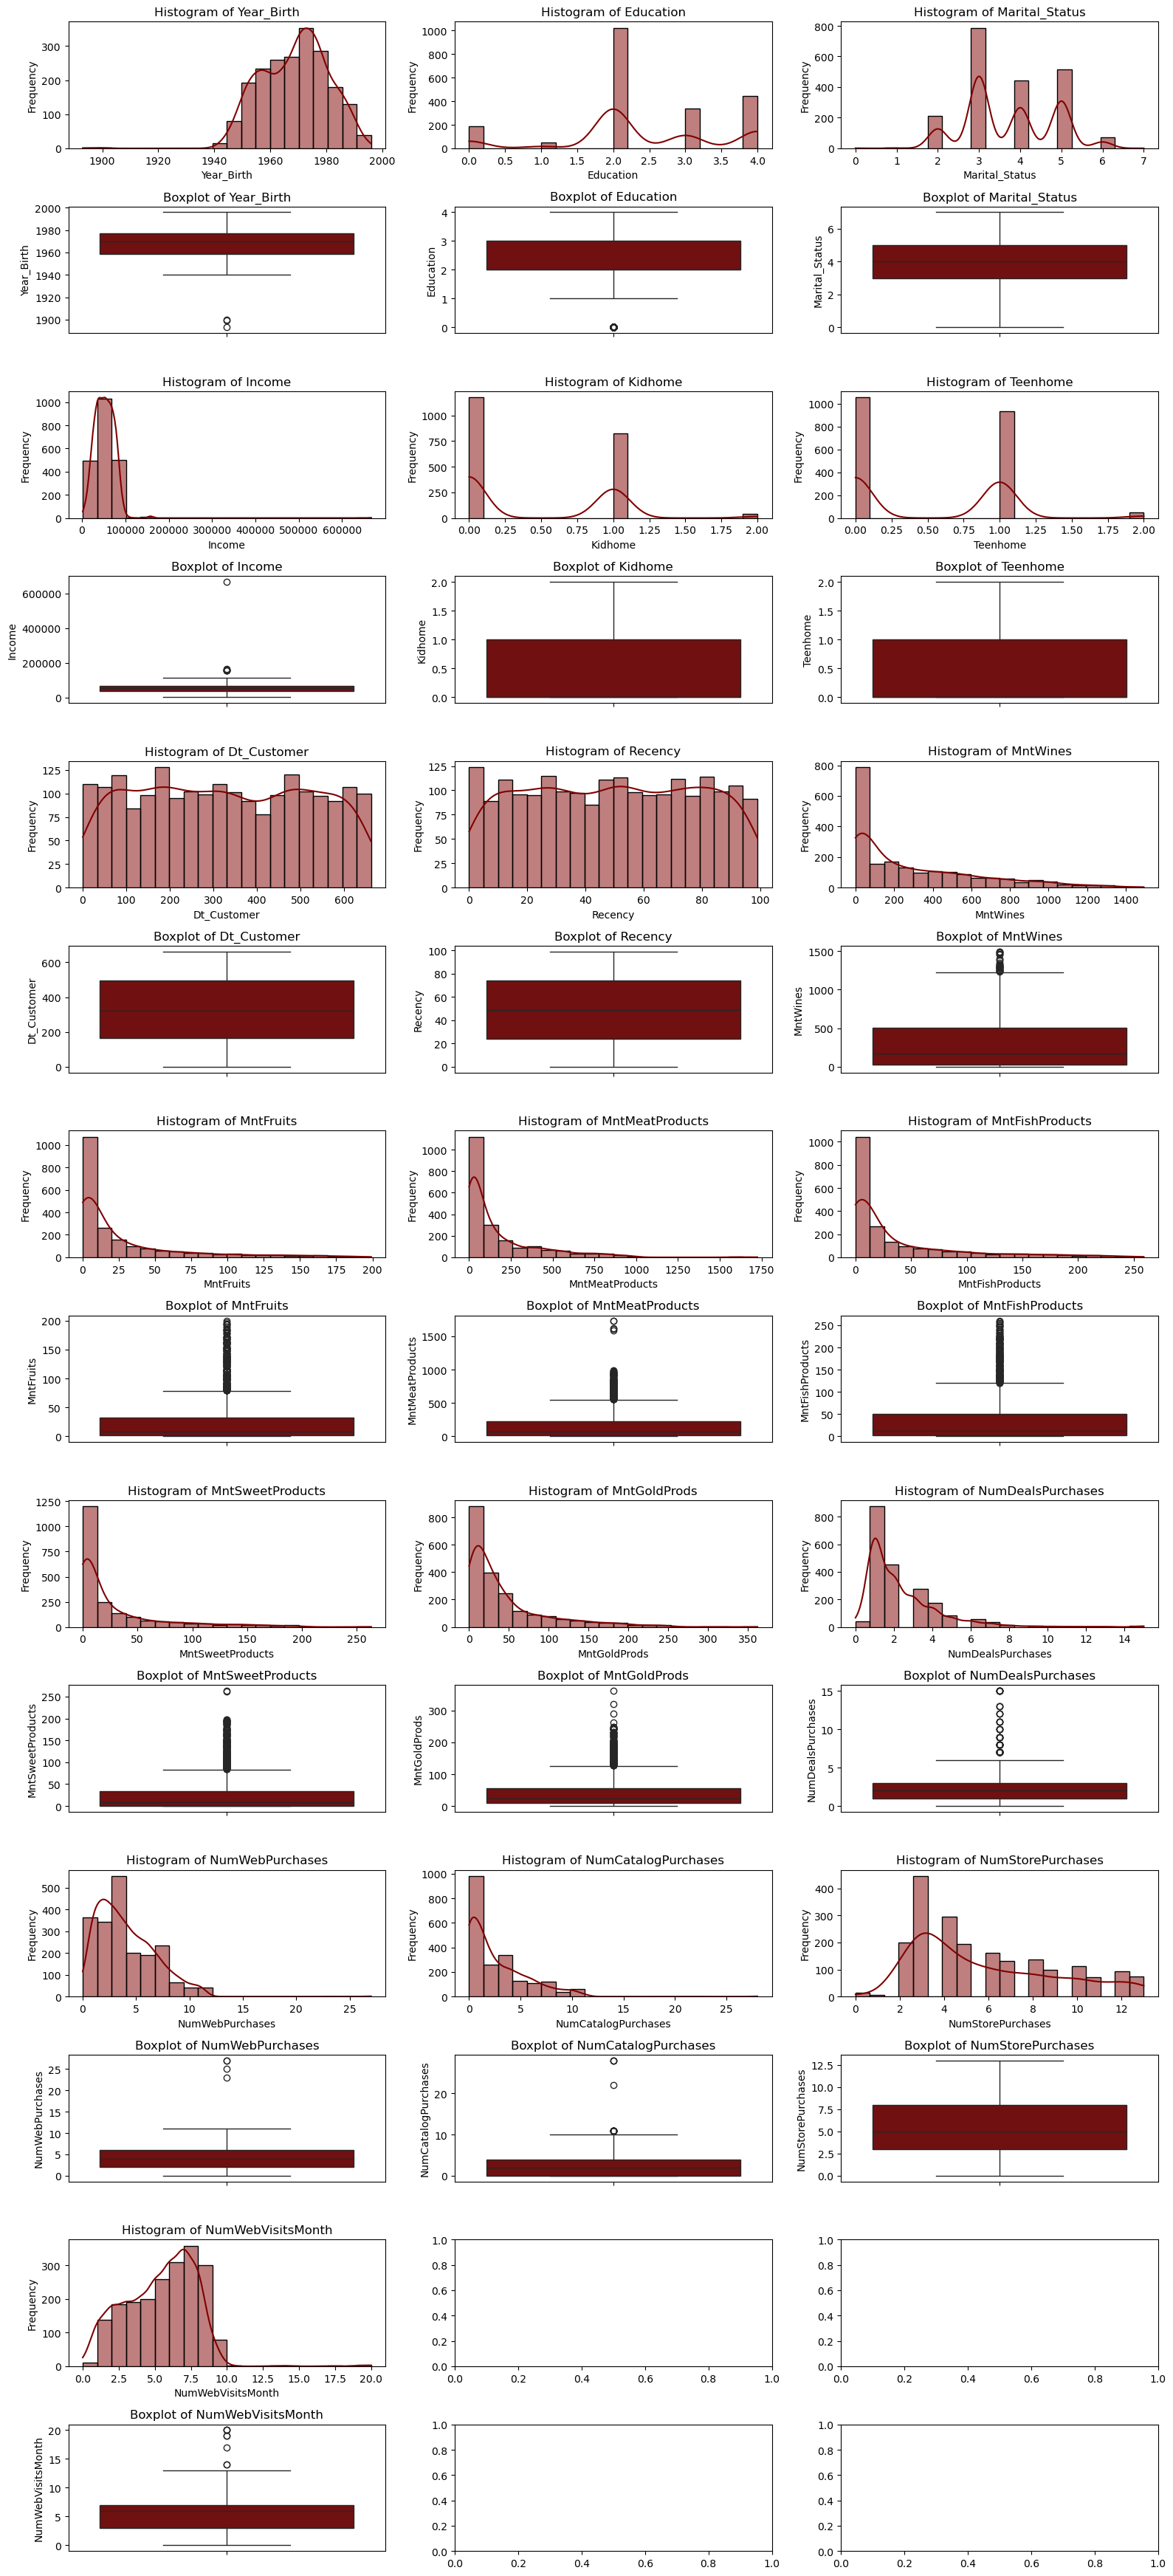

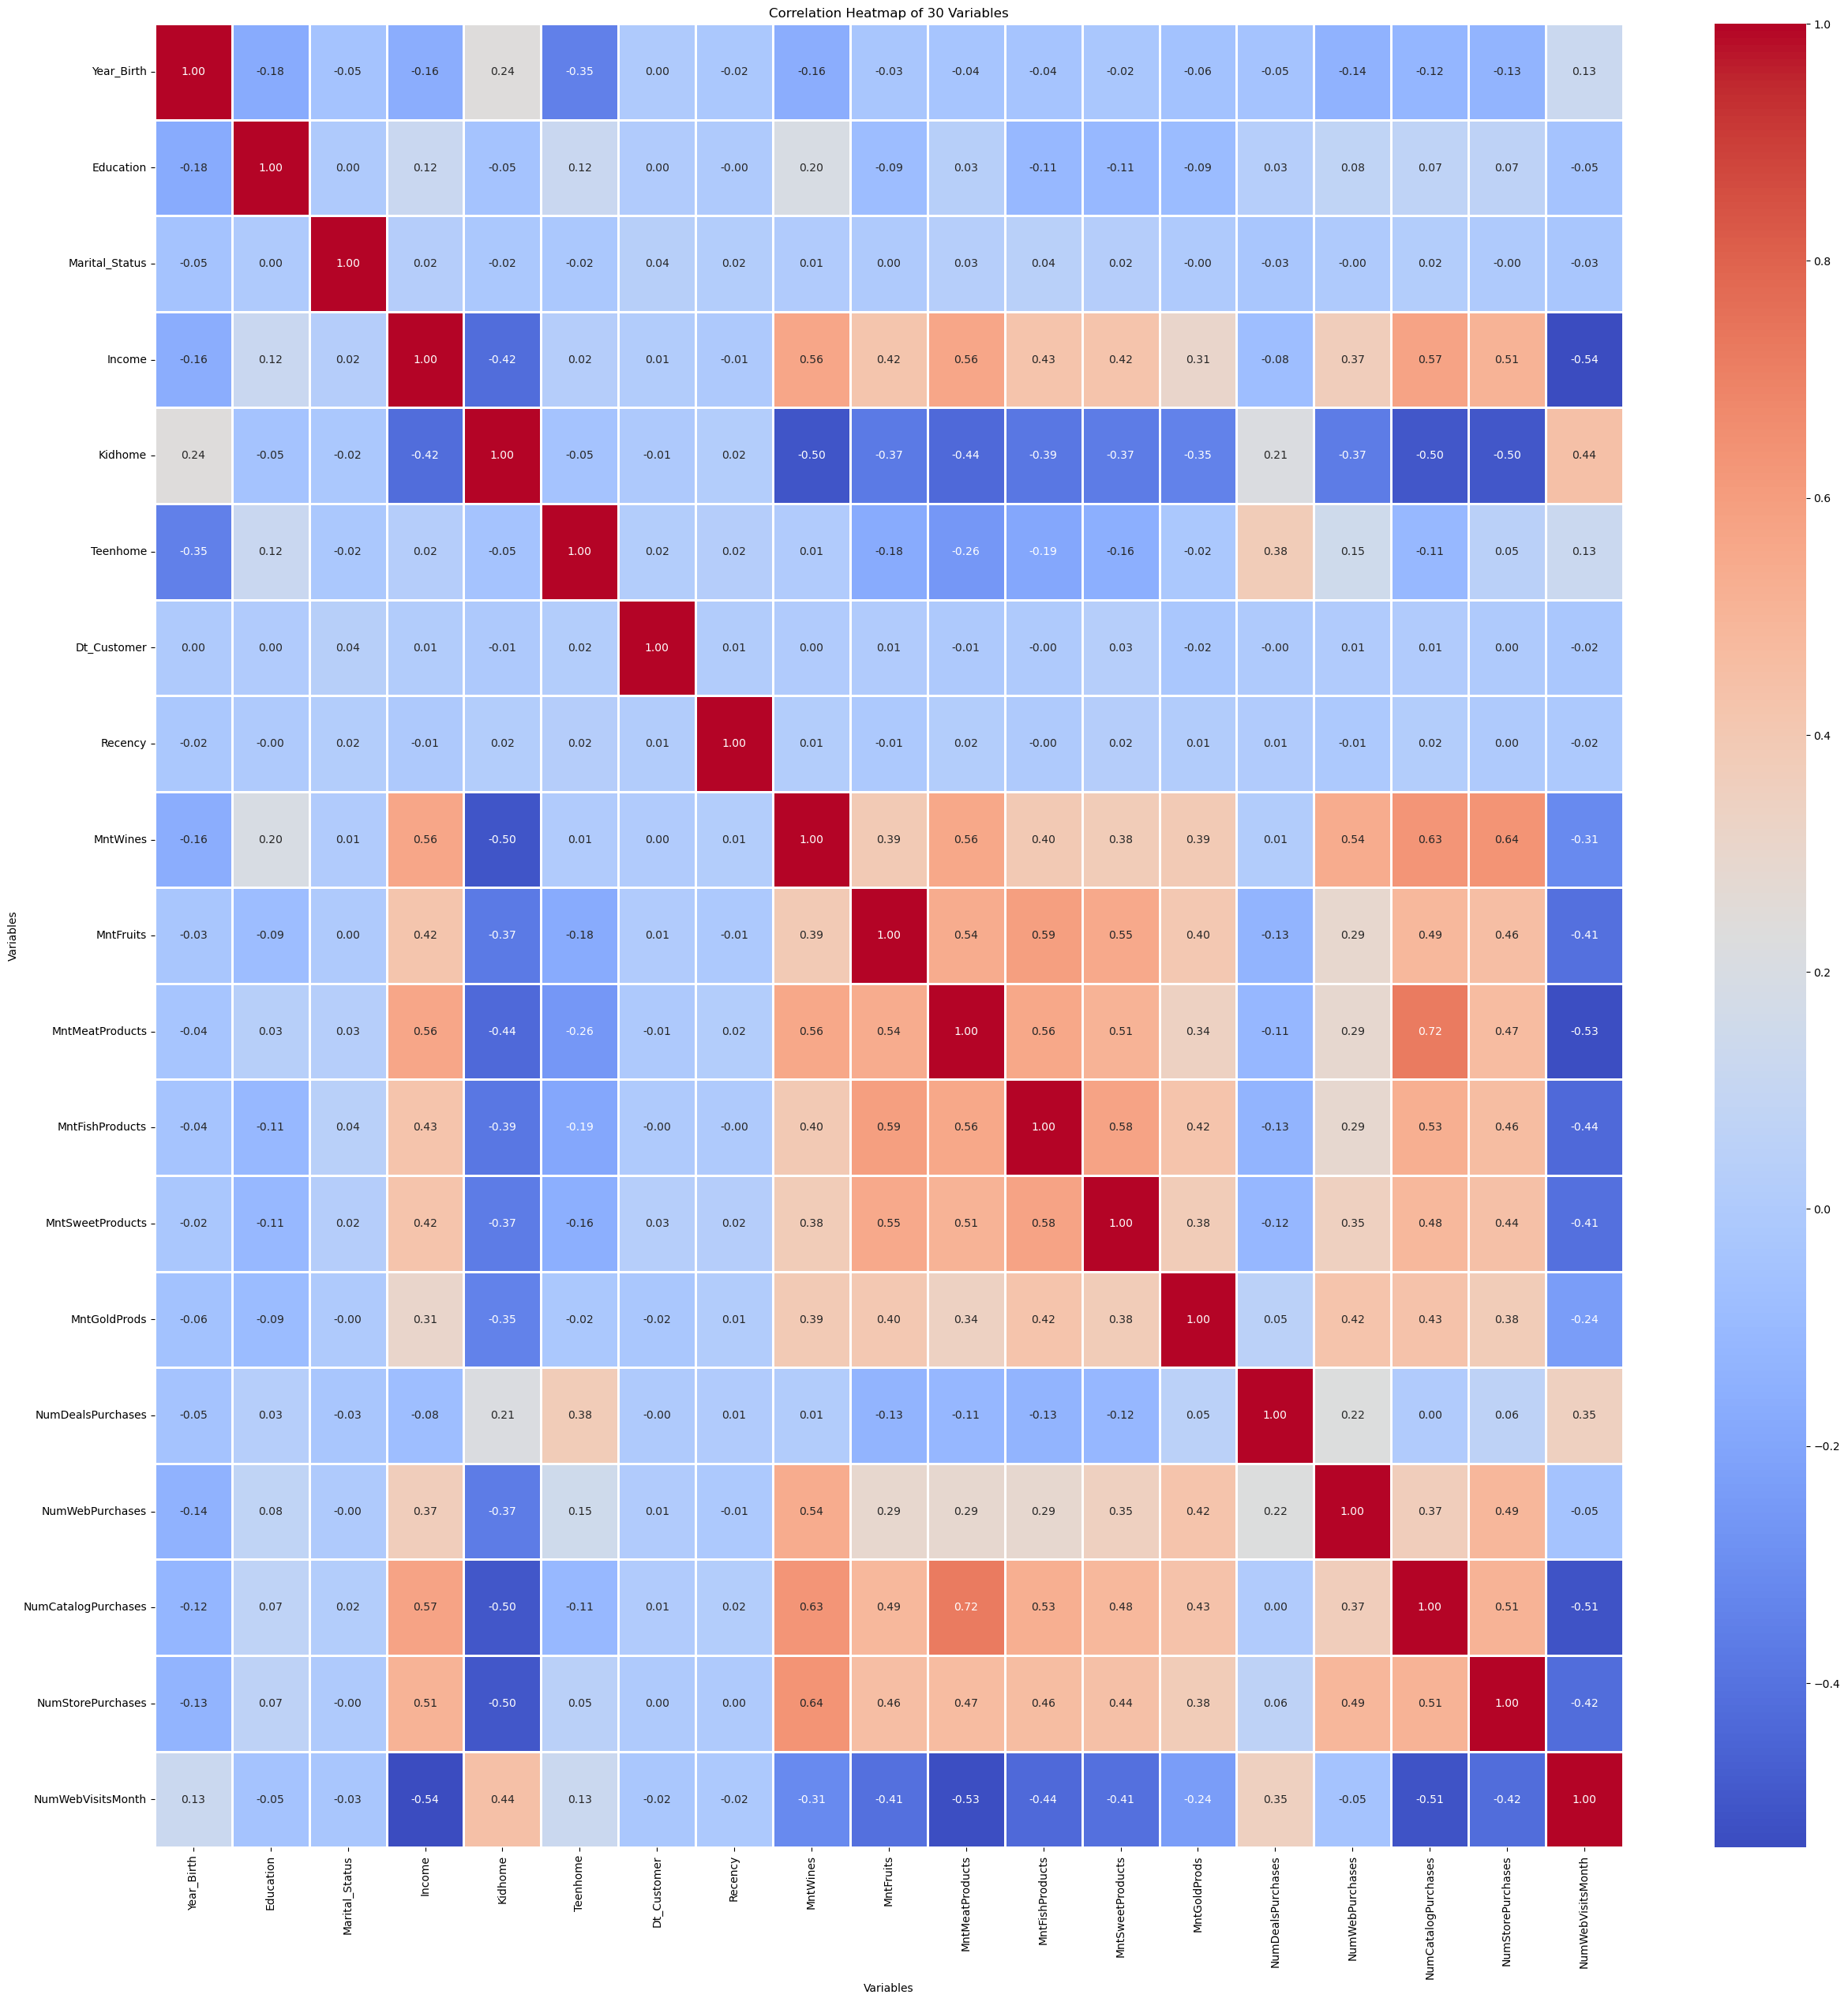

In [247]:
FtrSlct(data);

In [333]:
import pandas as pd
import numpy as np

def drop_highly_correlated(data, threshold=0.8):
    """
    Drop columns from a DataFrame based on high correlation between columns.
    
    Parameters:
    - df: DataFrame
    - threshold: Correlation threshold to identify highly correlated columns (default=0.8)
    
    Returns:
    - DataFrame with highly correlated columns removed
    """
    # Step 1: Calculate the correlation matrix
    corr_matrix = data.corr().abs()
    
    # Step 2: Identify columns to drop (those with correlations above the threshold)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Step 3: Find index of columns with correlation greater than the threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    
    print(f"Columns to drop: {to_drop}")
    
    # Step 4: Drop the highly correlated columns
    df_reduced = data.drop(columns=to_drop)
    
    return df_reduced

# Example usage:
correlated_columns = drop_highly_correlated(data, threshold=0.39)


Columns to drop: ['Kidhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']


In [335]:
data= data.drop(columns=['Kidhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'])


In [337]:
data = remove_outliers_iqr(data)


In [339]:
data

,Year_Birth,Education,Marital_Status,Income,Teenhome,Dt_Customer,Recency,NumDealsPurchases
0,1957.0,2.0,4.0,58138.0,0.0,553.0,58.0,3.0
1,1954.0,2.0,4.0,46344.0,1.0,629.0,38.0,2.0
2,1965.0,2.0,5.0,71613.0,0.0,293.0,26.0,1.0
3,1984.0,2.0,5.0,26646.0,0.0,31.0,26.0,2.0
4,1981.0,4.0,3.0,58293.0,0.0,216.0,94.0,5.0
...,...,...,...,...,...,...,...,...
2232,1986.0,2.0,4.0,26816.0,0.0,183.0,50.0,1.0
2235,1967.0,2.0,3.0,61223.0,1.0,98.0,46.0,2.0
2237,1981.0,2.0,2.0,56981.0,0.0,370.0,91.0,1.0
2238,1956.0,3.0,5.0,69245.0,1.0,349.0,8.0,2.0


In [341]:
# Example usage:
data = normalize_data(data)

Feature 'Year_Birth' - Min: 0.0, Max: 1.0
Feature 'Education' - Min: 0.0, Max: 1.0
Feature 'Marital_Status' - Min: 0.0, Max: 1.0
Feature 'Income' - Min: 0.0, Max: 1.0000000000000002
Feature 'Teenhome' - Min: 0.0, Max: 1.0
Feature 'Dt_Customer' - Min: 0.0, Max: 1.0
Feature 'Recency' - Min: 0.0, Max: 1.0
Feature 'NumDealsPurchases' - Min: 0.0, Max: 1.0


First selecting the best parameters.

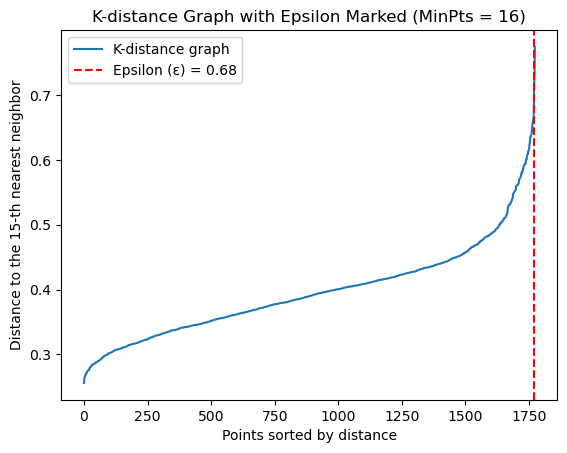

Optimal epsilon (ε) for DBSCAN: 0.68


In [259]:
# Example usage with your data
sorted_distances, epsilon = k_distance_graph(data)

# Print the final epsilon value
print(f"Optimal epsilon (ε) for DBSCAN: {epsilon:.2f}")


GRID SEARCH WITH TSNE

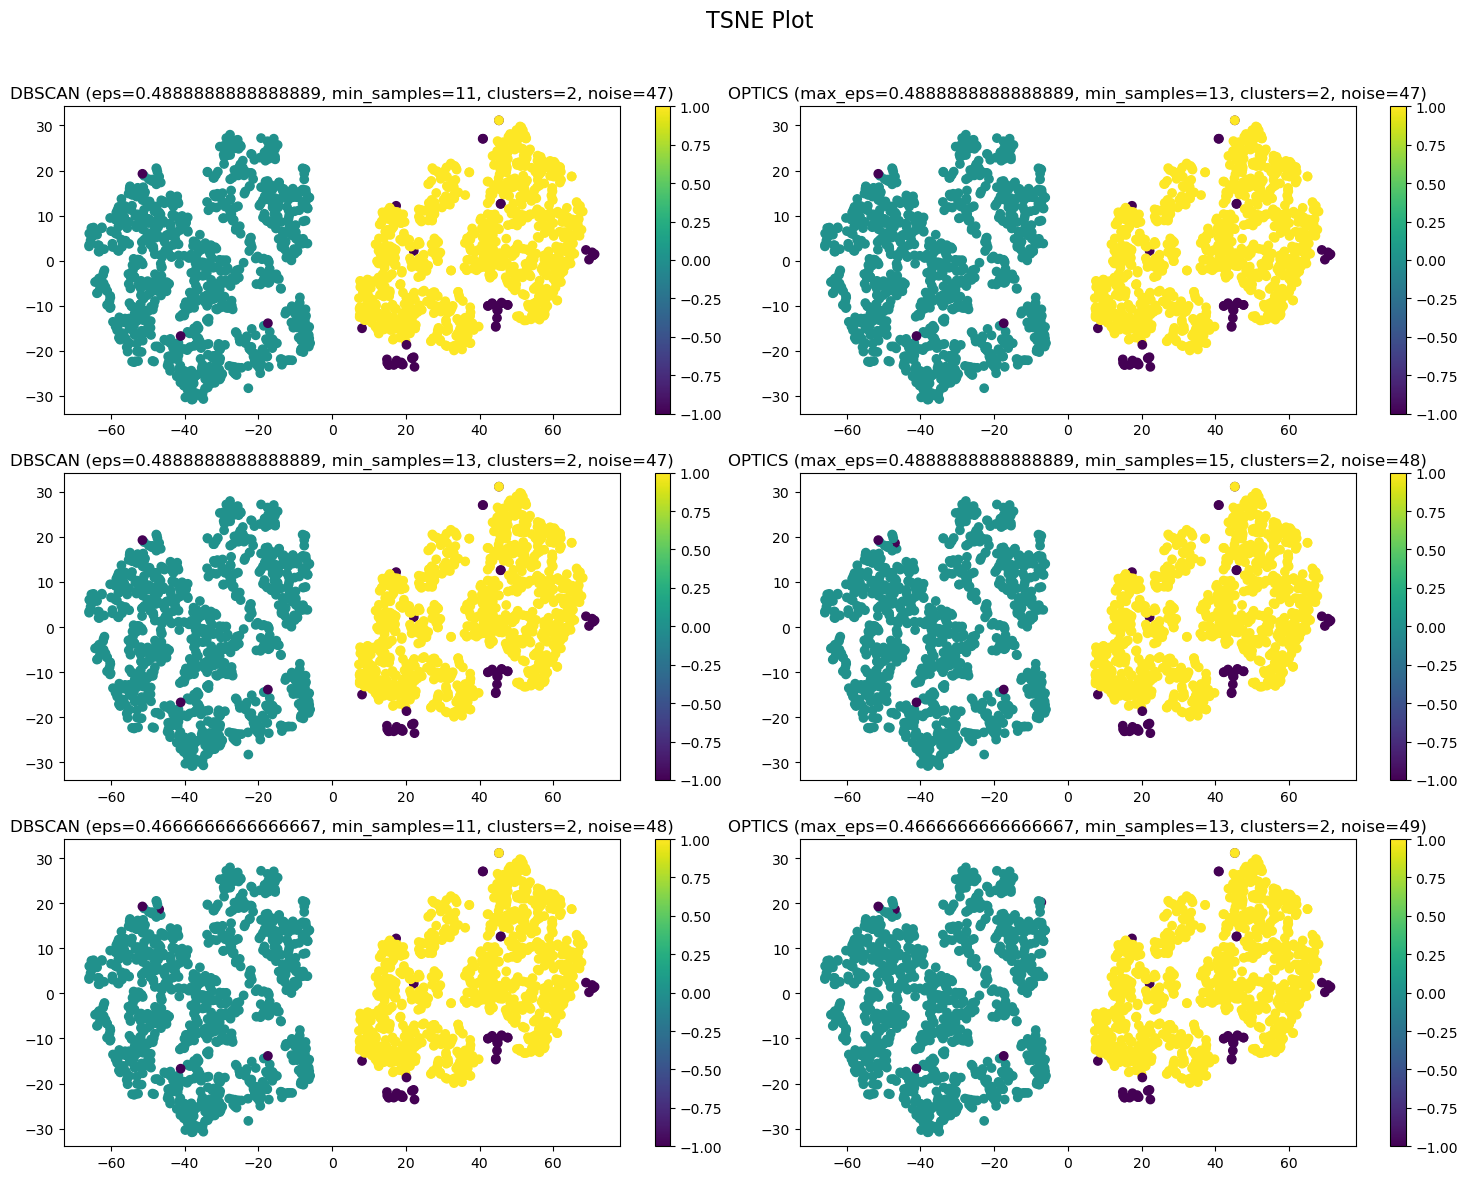

In [283]:
tsne_perform_clustering_and_plot(data)

In [ ]:
Two clusters are formed after grid search in TSNE

In [ ]:
PCA

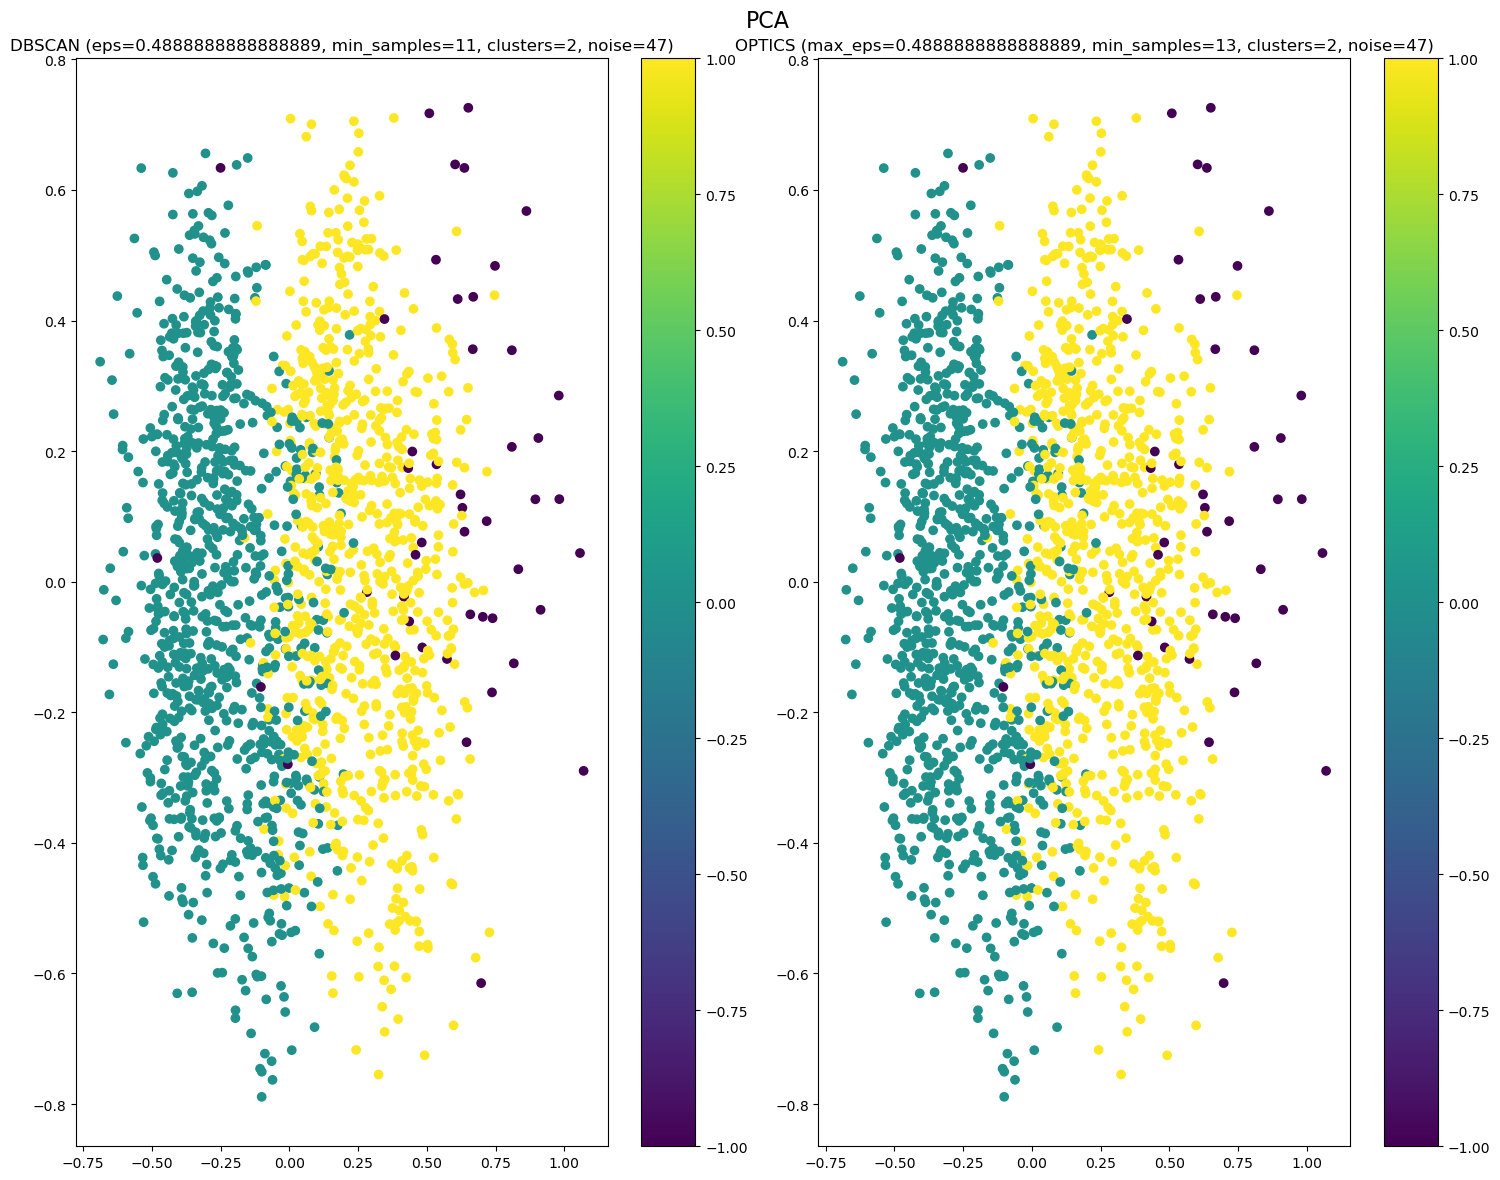

In [291]:
# Define DBSCAN and OPTICS parameters
dbscan_params = (0.4888888888888888888, 11)  # (eps, min_samples)
optics_params = (0.4888888888888888888, 13)  # (max_eps, min_samples)

# Perform clustering and plot
perform_clustering_and_plot(data, dbscan_params, optics_params)


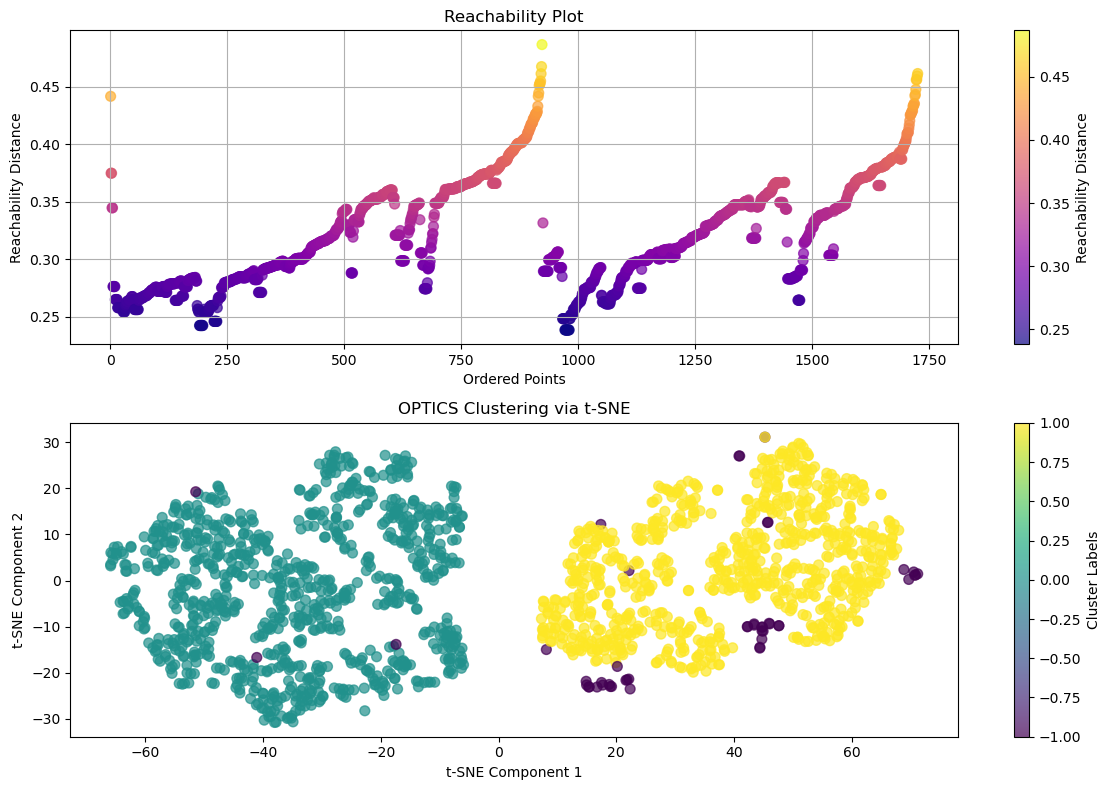

In [358]:


max_eps = 0.488888  # Example max epsilon for OPTICS
min_samples = 13  # Example minimum samples for OPTICS

reachability_plot_and_optics_curves(data, max_eps, min_samples)


with 'eps':0.4888888888888888888, 'min_samples': 11, 'min_samples': 13, 'max_eps':0.4888888888888888888

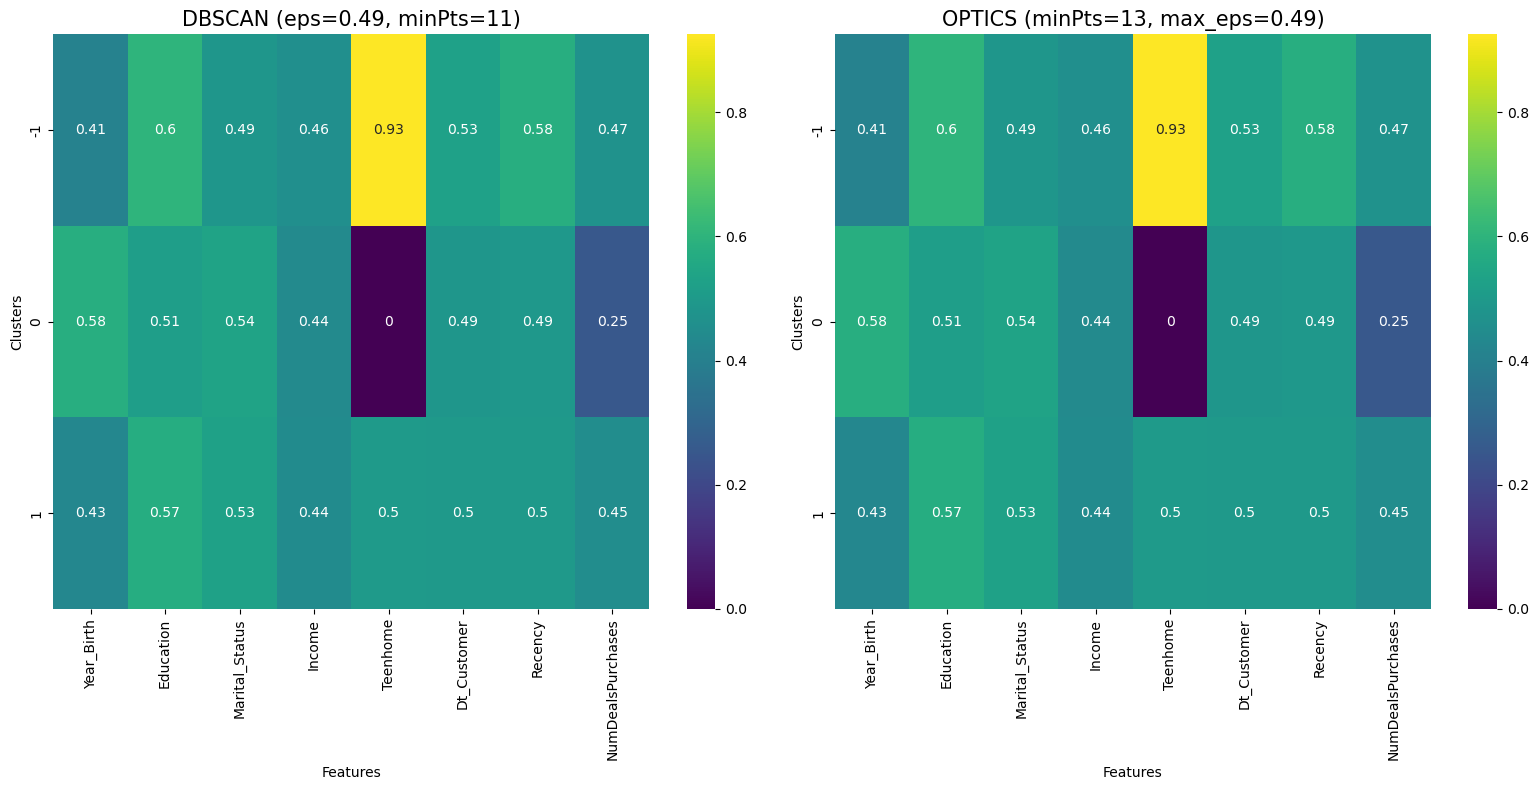

In [366]:
HeatmapFeatureMeansWithClustering(data, eps=0.49, minPts_dbscan=11, minPts_optics=13, max_eps=0.49, show_optics=True)


Both identifies two main clusters: high spenders (Cluster 1), low activity users (Cluster 0)

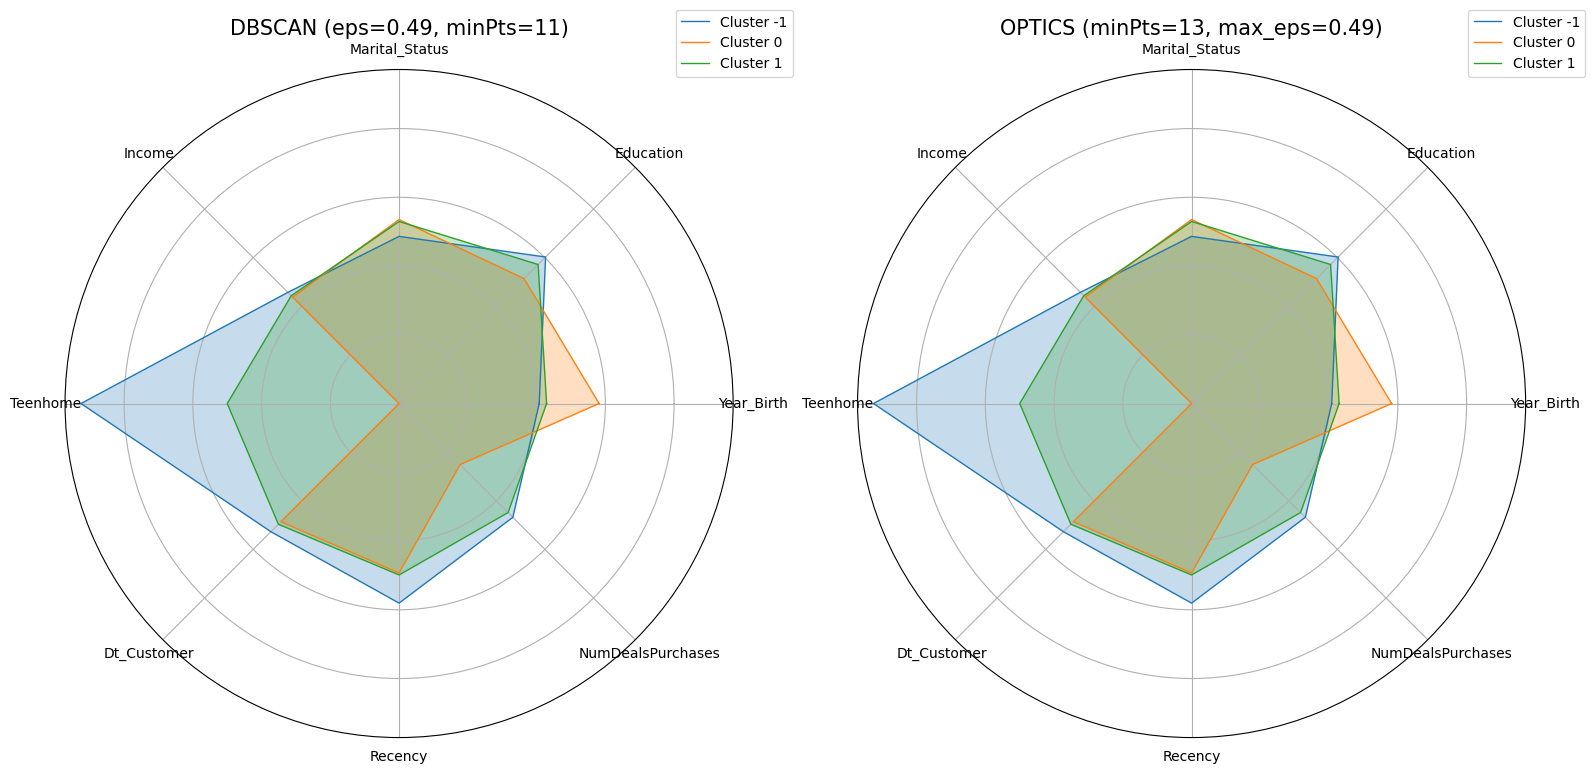

In [372]:
RadialFeatureMeansWithClustering(data, eps=0.49, minPts_dbscan=11, minPts_optics=13, max_eps=0.49, show_optics=True)


Both identifies two main clusters: high spenders (Cluster 1), low activity users (Cluster 0)

In [ ]:
Increasing of eps

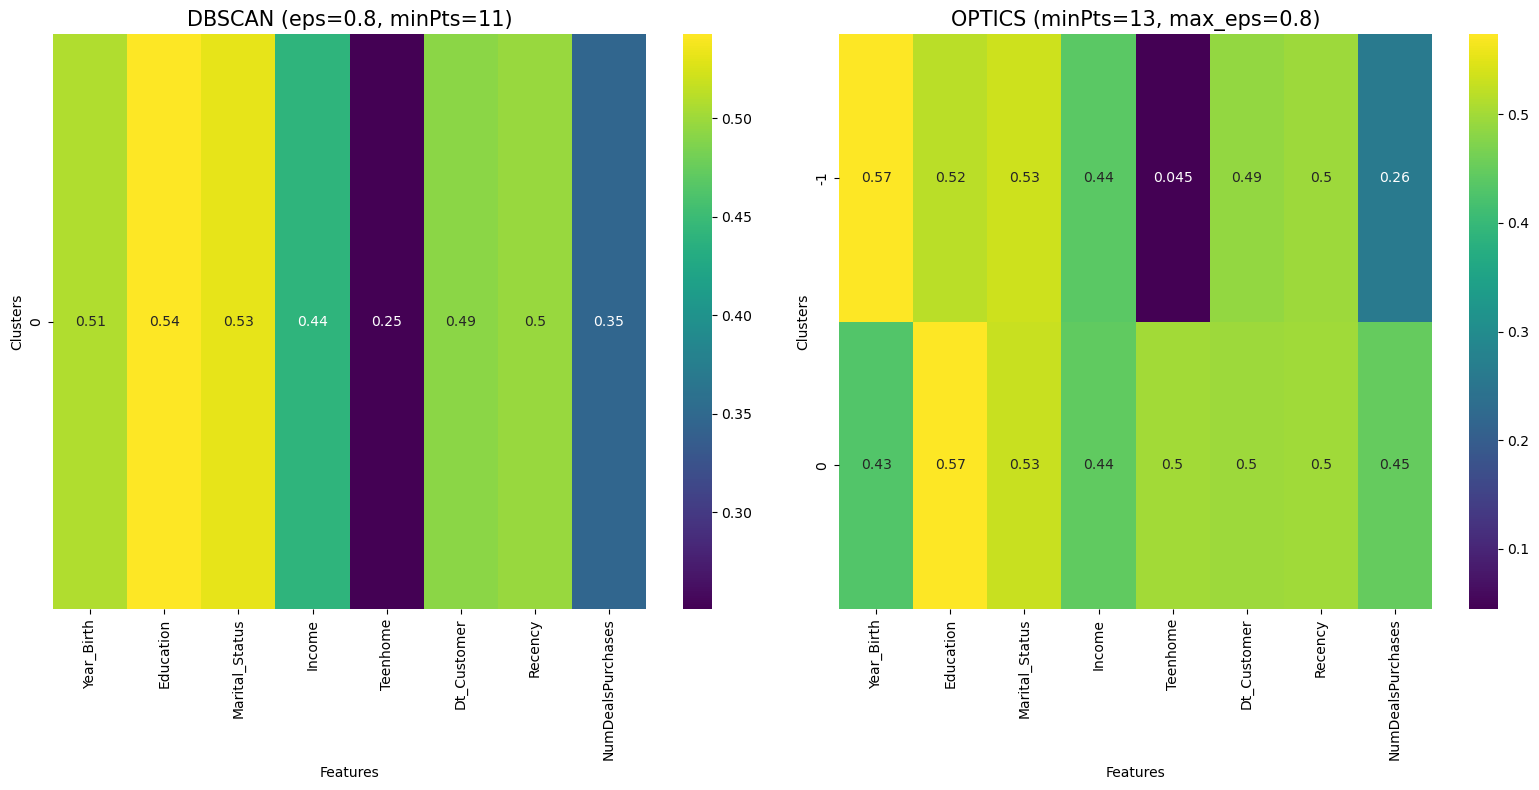

In [376]:
HeatmapFeatureMeansWithClustering(data, eps=0.8, minPts_dbscan=11, minPts_optics=13, max_eps=0.8, show_optics=True)


In [ ]:
No of clusters decreases

Decreasing of eps

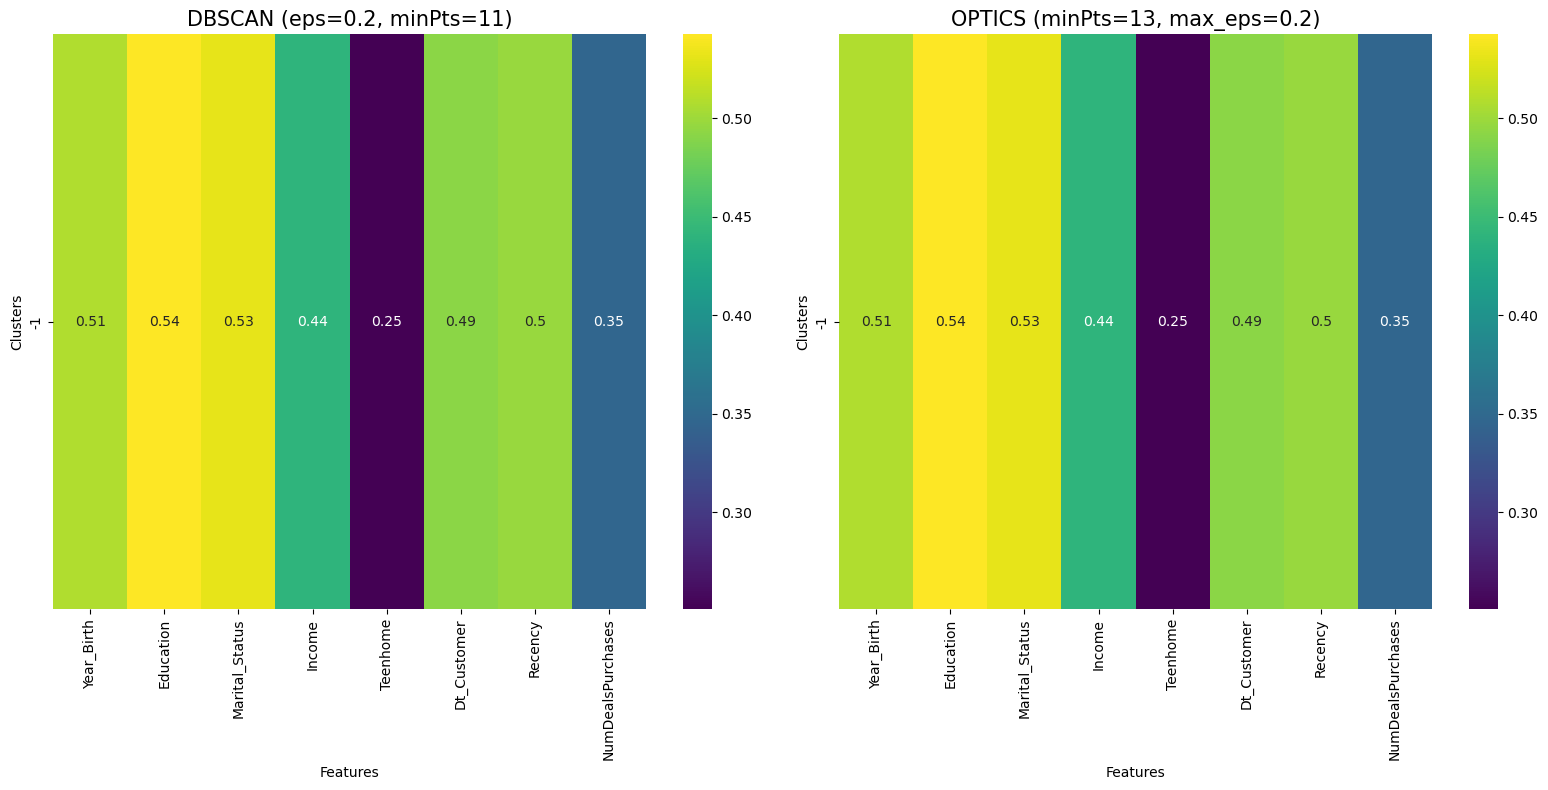

In [378]:
HeatmapFeatureMeansWithClustering(data, eps=0.2, minPts_dbscan=11, minPts_optics=13, max_eps=0.2, show_optics=True)


In [ ]:
No clusters formed by decreasing the eps

In [ ]:
Now by increasing and decreasing the minimum points of DBSCAN and DBSCAN optics 

In [ ]:
Increasing of minimum of points 

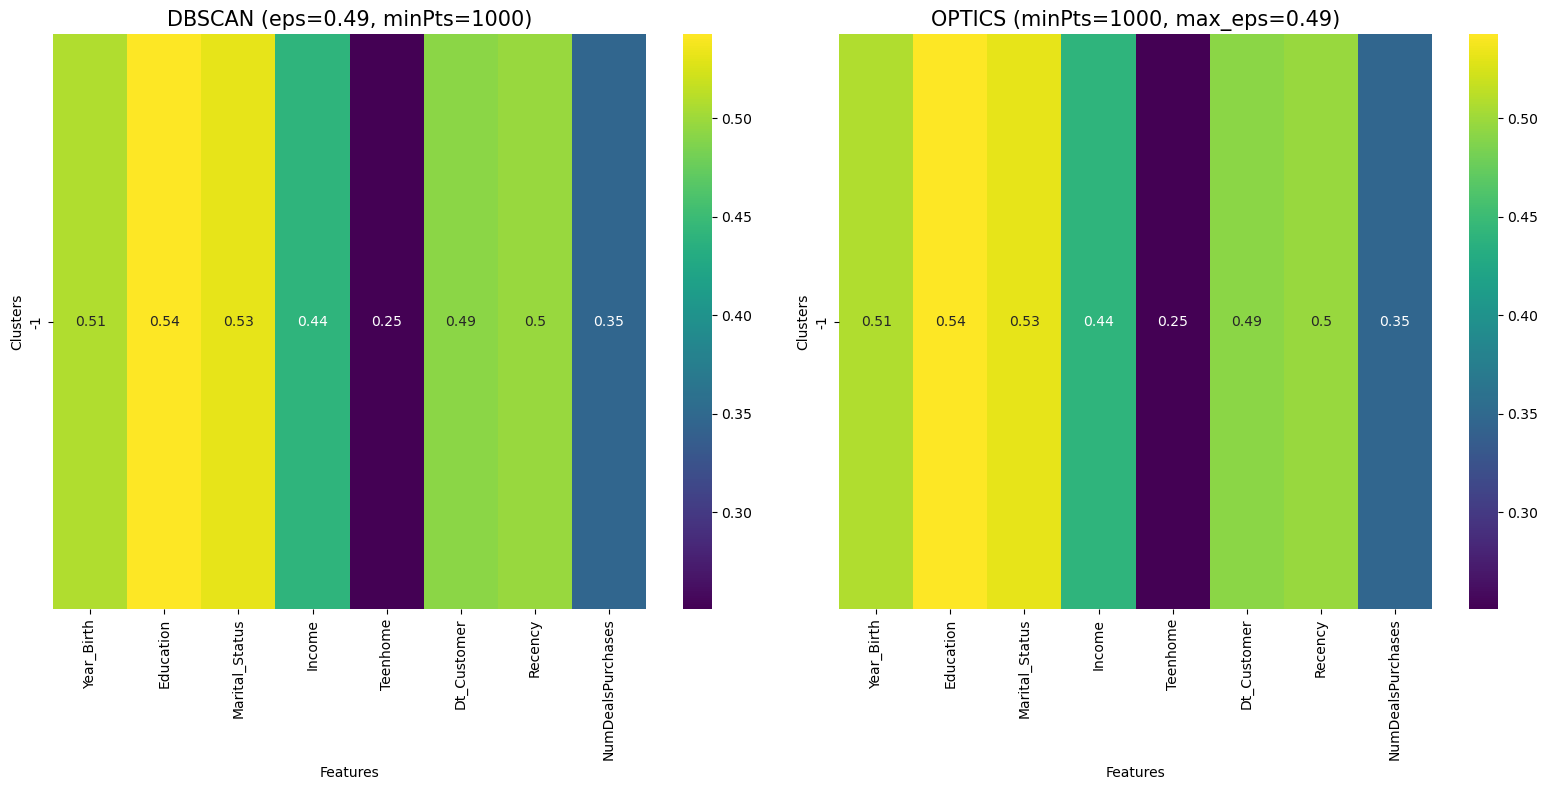

In [382]:
HeatmapFeatureMeansWithClustering(data, eps=0.49, minPts_dbscan=1000, minPts_optics=1000, max_eps=0.49, show_optics=True)

In [ ]:
No clusters are formed 

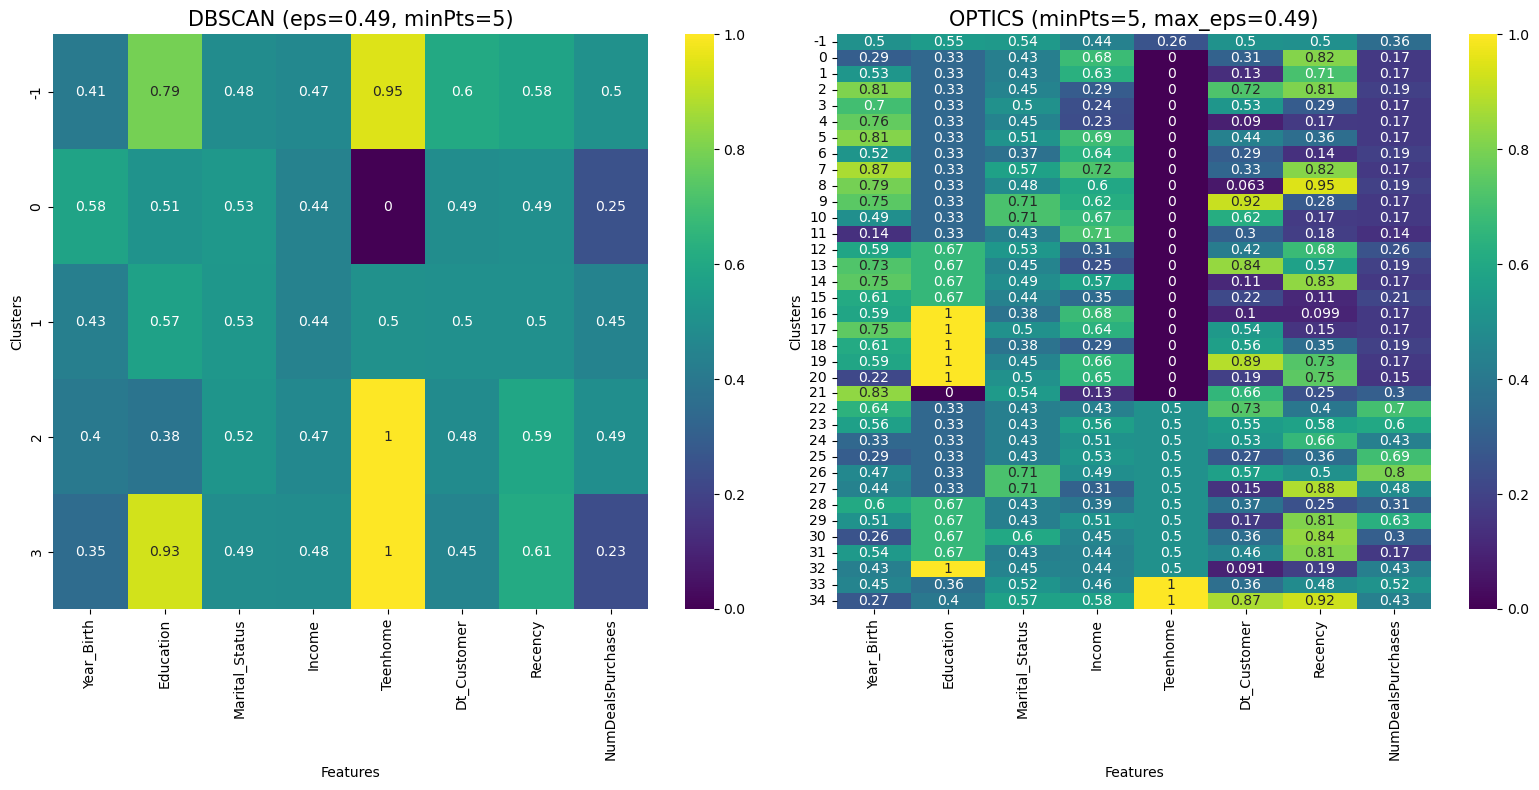

In [384]:
HeatmapFeatureMeansWithClustering(data, eps=0.49, minPts_dbscan=5, minPts_optics=5, max_eps=0.49, show_optics=True)

No of clusters increases

Overall result:
Optics give realistic interpretations where  DBSCAN did not handle noise well